# load_cbpnet_data.ipynb

The goal is to see if we can use the coordinates to load 32kb data from the coordinates instead of using the whole

We will just use peak regions for now and not focus on nonpeak regions. no bias model either, but first let's load the data

The peak regions are fine,b ut nonpeak region sneed to be GC matched across the 32kb so we can adapt their code

In [1]:
#first load in the data of coordinates and seq
import numpy as np
arraypath = '/data/leslie/sarthak/data/chrombpnet_test/saved_data_1000/train/'
peak_seqs = np.load(arraypath + 'peak_seqs.npy')
peak_coords = np.load(arraypath + 'peak_coords.npy')
peak_cts = np.load(arraypath + 'peak_cts.npy')
print(peak_seqs.shape, peak_coords.shape, peak_cts.shape)

(220311, 2024, 4) (220311, 4) (220311, 1800)


In [2]:
print(peak_coords[0])
print(peak_cts[0]) #the idea is we want to get something that matches this
print(peak_seqs[0]) #and something that matches this

['chr1' '100029207' 'f' '1']
[0. 0. 1. ... 0. 0. 0.]
[[0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 ...
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]


In [4]:
#let's get the bigwig file and use what they use to laod the data
import pyBigWig
import pyfaidx
#it is indeed centered around this r summit + r start, where summit is how far into the peak the summit is
cts_bw_file = '/data/leslie/sarthak/data/chrombpnet_test/chrombpnet_model_1000/auxiliary/data_unstranded.bw'
genome_fasta = '/data/leslie/sarthak/data/chrombpnet_test/hg38.fa'
cts_bw = pyBigWig.open(cts_bw_file)
genome = pyfaidx.Fasta(genome_fasta)

In [7]:
width=1800
test_cts = np.nan_to_num(cts_bw.values('chr1', 100029207-width//2, 100029207+width//2))
print(test_cts.shape)
print(test_cts[:20])
print(peak_cts[0][:20])

(1800,)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
print(np.allclose(test_cts, peak_cts[0]))
#yeah it's quite easy to extract these sequences!
#and it is indeed centered around the summit not the start or the middle

True


In [15]:
#let's test with the sequence too
width=2024
test_seq = genome['chr1'][100029207-width//2:100029207+width//2].seq
# print(test_seq.shape)
print(test_seq)

CCCAAAGTGCTGGGTTTACAGGCGTGAGCCGCTGCGCCCGGCCAATACTGCCTTTCAAAAGAGACTGATAGTGACCAGCATTAGTAATCATACTGGTGGGGTTTTTTGGGGTGTTTTTCTGTTTTGTTTTTTGTTTTTTGTTTTTGAGACAAGGTCTTCCTCCCGTTGCCTAGGCTGGAGTGCGGTGACACAATCTTGGCTCACTGCAGCCTTGATAGAGCAAGCTCAAGTGATCCTCCCAGGAGCCTCGGCCCCCAAGCAGCTGGGAATACAGGTGCGCGCCACCATGCCCAGCTGATTTTTGTATTTTTTTGTAGAGATGGGGTTTTGCCATGTTGCCCGGATTGGTCTCAAACTCCTGAGCTTCAGTGATCTGCCTGCCTTGGCCTCCCAAAGTGTTGGGATTACAGGCGTGAGCGACCACACCCAGCCCATATTGGTCTTTCTTACTGTTCTTAAAAAGAGAATTCCTTTAAGGCAGGACCGATTACATATACACTCTAGAAAAGAAAATAGCAAGGAAGAAATAAATTGCCTTCAATTACCAAAGATTTGAGCTTCTGCTATGGCTGAGAGTGTTTTGGTCATTGCAAATTCAGGGGTTTCCCAAGTTCACCCTCAGTTCTGGCTAGAAAGAGAAAACTTACTAAAAGCTATTATACTCACAGTCATATTTATTACAGAGAAAGGAAATACAAATTAAAACCAGCCAAAGGAAGTGACACATAAAACAGAGTCTAGGAGTGGTCCAAACTTGAGGCTTTCGGTGTCCTTTTCTTGTAGCGTCATGGAAGGTGTTATCTACTCCTGACCACAATGTTTGACAGTACACACATAGTATTGCCATTCAGGGAAGCTCACCTAAGCTTTGGTGTCCAGATTTTTATTGAGAGAGGCTCTATTAGTTGGCATGGTTGGTTGATTTTTTTGCCCATGTAGTTGTCCTCTCTTTCCAACATCTGCCCCTCCCTGGAGATCTGGTTGACATCAAGACTTCAGG

In [16]:
#first convert onehot to string
def onehot_to_seq(onehot):
    seq = ''
    for i in range(onehot.shape[0]):
        if onehot[i,0] == 1:
            seq += 'A'
        elif onehot[i,1] == 1:
            seq += 'C'
        elif onehot[i,2] == 1:
            seq += 'G'
        elif onehot[i,3] == 1:
            seq += 'T'
    return seq
print(a:=onehot_to_seq(peak_seqs[0]))

CCCAAAGTGCTGGGTTTACAGGCGTGAGCCGCTGCGCCCGGCCAATACTGCCTTTCAAAAGAGACTGATAGTGACCAGCATTAGTAATCATACTGGTGGGGTTTTTTGGGGTGTTTTTCTGTTTTGTTTTTTGTTTTTTGTTTTTGAGACAAGGTCTTCCTCCCGTTGCCTAGGCTGGAGTGCGGTGACACAATCTTGGCTCACTGCAGCCTTGATAGAGCAAGCTCAAGTGATCCTCCCAGGAGCCTCGGCCCCCAAGCAGCTGGGAATACAGGTGCGCGCCACCATGCCCAGCTGATTTTTGTATTTTTTTGTAGAGATGGGGTTTTGCCATGTTGCCCGGATTGGTCTCAAACTCCTGAGCTTCAGTGATCTGCCTGCCTTGGCCTCCCAAAGTGTTGGGATTACAGGCGTGAGCGACCACACCCAGCCCATATTGGTCTTTCTTACTGTTCTTAAAAAGAGAATTCCTTTAAGGCAGGACCGATTACATATACACTCTAGAAAAGAAAATAGCAAGGAAGAAATAAATTGCCTTCAATTACCAAAGATTTGAGCTTCTGCTATGGCTGAGAGTGTTTTGGTCATTGCAAATTCAGGGGTTTCCCAAGTTCACCCTCAGTTCTGGCTAGAAAGAGAAAACTTACTAAAAGCTATTATACTCACAGTCATATTTATTACAGAGAAAGGAAATACAAATTAAAACCAGCCAAAGGAAGTGACACATAAAACAGAGTCTAGGAGTGGTCCAAACTTGAGGCTTTCGGTGTCCTTTTCTTGTAGCGTCATGGAAGGTGTTATCTACTCCTGACCACAATGTTTGACAGTACACACATAGTATTGCCATTCAGGGAAGCTCACCTAAGCTTTGGTGTCCAGATTTTTATTGAGAGAGGCTCTATTAGTTGGCATGGTTGGTTGATTTTTTTGCCCATGTAGTTGTCCTCTCTTTCCAACATCTGCCCCTCCCTGGAGATCTGGTTGACATCAAGACTTCAGG

In [17]:
a == test_seq

True

it would also be very easy to go from the bed if we had our list of seqs in bed format, as we can just add in the start and summit to get the new summit. But that's besides the point

In [4]:
#now let's import the tokenizer
import sys
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
import pyBigWig
import pyfaidx
#it is indeed centered around this r summit + r start, where summit is how far into the peak the summit is
cts_bw_file = '/data/leslie/sarthak/data/chrombpnet_test/chrombpnet_model_1000/auxiliary/data_unstranded.bw'
genome_fasta = '/data/leslie/sarthak/data/chrombpnet_test/hg38.fa'
cts_bw = pyBigWig.open(cts_bw_file)
genome = pyfaidx.Fasta(genome_fasta)

import numpy as np

arraypath = '/data/leslie/sarthak/data/chrombpnet_test/saved_data_1000/train/'
peak_seqs = np.load(arraypath + 'peak_seqs.npy')
peak_coords = np.load(arraypath + 'peak_coords.npy')
peak_cts = np.load(arraypath + 'peak_cts.npy')
print(peak_seqs.shape, peak_coords.shape, peak_cts.shape)

tokenizer = CharacterTokenizer(
    characters=['A', 'C', 'G', 'T', 'N'],
    model_max_length=32770,  # add 2 since default adds eos/eos tokens, crop later
    add_special_tokens=False,
    
)

(220311, 2024, 4) (220311, 4) (220311, 1800)


In [5]:
#if we do 1 million bp, we certainly cannot save it out, so instead have this widgth parameter!

width = 32768
seq1 = genome['chr1'][100029207-width//2:100029207+width//2].seq
print(len(seq1), seq1)

32768 ACATTTAGAGGGCTGGTTAAATAAATTATCAGTATAATACATAGTATAGTGATTAAGATCATGTTCTCTCCTGAGCCCATGATTTACCAGTAGTGTGAGCTTGGGCAAGTTATGTAACCTCTCTGTGCTTCAGTTTCTTCATCTATAAAATAGACATCTACCTCATAGTGTTGTATGTGAGTTAACATACATGAAGCACTTAGAATAATTCTTGTTACATGCTGATACATACATATTTGCTATTATAATCCATACAAAGGAATATTATGCAACTGTTAGAATGCAGTAGTTCTGTTCATACTGACATGTATATATCCTTCTATAATGTATACTTTTTTAGTAATTACAAAGTCTTTTATAAATTAAAAAACTTTATTGGGTTTGGTGGCTTGTGCTTCTAATCCCAGATACTTGGGAGGCTGAGATGGGAGGATTGCTTGAGAACCAGGAGTTTTGAGACCTGAGCAACATAGTGAGACCCTGTTTCTTAAAAATATATATATATAAGCCTGGATACAGTGGCTCACGCCTGTAATCCCAGCACTTTGAGAGGCCGAGGCAGGTGGATTGTTTGAGCTTAGGAATTGGAGACCAGTCTGAGCAACACTACAAAACTCTGTACAAAAAAAAAAAAAAAAAATTAGCTGGGTGTGGTAGCGTGTGCCTGTGGTCCAAGCTACTTCGGAGGCTGAGGTGGGAGGATCGCTTGAGTCCAAGAAGTCGAGGCTGCAGTGAGTTGTGATTGTGCCTCTGCACTCCAGCCTGCTAAGTGACAGAGTGAAATCCTGTCTCAAAATATACATATACATATATATATGTTATATATAAAACTCTTCTGATGGTATTTTATATATGTGTGTATATATATACACACACATACCTATTTTATATATATGTAATACCATCATATAAAATACCATCACATGTGTTTTTGTAATTATATGCCAGCATTAATTTCATGTTTGAAATTAGACATTAAAAGGATAGAGCTGAC

In [7]:
tokenizer._vocab_int_to_str

{0: '[CLS]',
 1: '[SEP]',
 2: '[BOS]',
 3: '[MASK]',
 4: '[PAD]',
 5: '[RESERVED]',
 6: '[UNK]',
 7: 'A',
 8: 'C',
 9: 'G',
 10: 'T',
 11: 'N'}

In [11]:
len(tokenizer.encode(seq1)) #adds one, the eos token
print(tokenizer.encode(seq1)[-10:]) #yeah uses sep as eos, but that's pretty good!
print(tokenizer.encode(seq1)[:10]) #no bos token is fine

[7, 10, 10, 10, 10, 9, 7, 10, 7, 1]
[7, 8, 7, 10, 10, 10, 7, 9, 7, 9]


In [20]:
#let's see what special tokens are

tokenizer2 = CharacterTokenizer(
    characters=['A', 'C', 'G', 'T', 'N'],
    model_max_length=32770,  # add 2 since default adds eos/eos tokens, crop later
    add_special_tokens=False,
    # padding='max_length',
    # truncation=True
)

print(tokenizer2._vocab_int_to_str)

{0: '[CLS]', 1: '[SEP]', 2: '[BOS]', 3: '[MASK]', 4: '[PAD]', 5: '[RESERVED]', 6: '[UNK]', 7: 'A', 8: 'C', 9: 'G', 10: 'T', 11: 'N'}


In [19]:
print(tokenizer2.encode(seq1)[-10:]) #yeah uses sep as eos, but that's pretty good!
print(tokenizer2.encode(seq1)[:10]) #no bos token is fine
#so is exactly the same, still adds an eos pretty much

[7, 10, 10, 10, 10, 9, 7, 10, 7, 1]
[7, 8, 7, 10, 10, 10, 7, 9, 7, 9]


In [23]:
a = tokenizer2(seq1, add_special_tokens=True, truncation=True, max_length=32770, padding='max_length')['input_ids']
print(a[-10:])
print(a[:10])

#ok so in this case a bos token is added

a = a[1:-1]
print(len(a))

[7, 10, 10, 10, 10, 9, 7, 10, 7, 1]
[4, 7, 8, 7, 10, 10, 10, 7, 9, 7]
32768


In [24]:
print(min(a), max(a)) #no special tokens anymore

7 10


In [28]:
#so now we can tokenize it, let's make this in the dataloader
peak_coords[0]

array(['chr1', '100029207', 'f', '1'], dtype='<U21')

In [14]:
def dna_to_one_hot(seqs):
    """
    Converts a list of DNA ("ACGT") sequences to one-hot encodings, where the
    position of 1s is ordered alphabetically by "ACGT". `seqs` must be a list
    of N strings, where every string is the same length L. Returns an N x L x 4
    NumPy array of one-hot encodings, in the same order as the input sequences.
    All bases will be converted to upper-case prior to performing the encoding.
    Any bases that are not "ACGT" will be given an encoding of all 0s.
    """
    seq_len = len(seqs[0])
    assert np.all(np.array([len(s) for s in seqs]) == seq_len)

    # Join all sequences together into one long string, all uppercase
    seq_concat = "".join(seqs).upper() + "ACGT"
    # Add one example of each base, so np.unique doesn't miss indices later

    one_hot_map = np.identity(5)[:, :-1].astype(np.int8)

    # Convert string into array of ASCII character codes;
    base_vals = np.frombuffer(bytearray(seq_concat, "utf8"), dtype=np.int8)

    # Anything that's not an A, C, G, or T gets assigned a higher code
    base_vals[~np.isin(base_vals, np.array([65, 67, 71, 84]))] = 85

    # Convert the codes into indices in [0, 4], in ascending order by code
    _, base_inds = np.unique(base_vals, return_inverse=True)

    # Get the one-hot encoding for those indices, and reshape back to separate
    return one_hot_map[base_inds[:-4]].reshape((len(seqs), seq_len, 4))

In [32]:
genome['chr1'][100029207-width//2:100029207+width//2].seq

'ACATTTAGAGGGCTGGTTAAATAAATTATCAGTATAATACATAGTATAGTGATTAAGATCATGTTCTCTCCTGAGCCCATGATTTACCAGTAGTGTGAGCTTGGGCAAGTTATGTAACCTCTCTGTGCTTCAGTTTCTTCATCTATAAAATAGACATCTACCTCATAGTGTTGTATGTGAGTTAACATACATGAAGCACTTAGAATAATTCTTGTTACATGCTGATACATACATATTTGCTATTATAATCCATACAAAGGAATATTATGCAACTGTTAGAATGCAGTAGTTCTGTTCATACTGACATGTATATATCCTTCTATAATGTATACTTTTTTAGTAATTACAAAGTCTTTTATAAATTAAAAAACTTTATTGGGTTTGGTGGCTTGTGCTTCTAATCCCAGATACTTGGGAGGCTGAGATGGGAGGATTGCTTGAGAACCAGGAGTTTTGAGACCTGAGCAACATAGTGAGACCCTGTTTCTTAAAAATATATATATATAAGCCTGGATACAGTGGCTCACGCCTGTAATCCCAGCACTTTGAGAGGCCGAGGCAGGTGGATTGTTTGAGCTTAGGAATTGGAGACCAGTCTGAGCAACACTACAAAACTCTGTACAAAAAAAAAAAAAAAAAATTAGCTGGGTGTGGTAGCGTGTGCCTGTGGTCCAAGCTACTTCGGAGGCTGAGGTGGGAGGATCGCTTGAGTCCAAGAAGTCGAGGCTGCAGTGAGTTGTGATTGTGCCTCTGCACTCCAGCCTGCTAAGTGACAGAGTGAAATCCTGTCTCAAAATATACATATACATATATATATGTTATATATAAAACTCTTCTGATGGTATTTTATATATGTGTGTATATATATACACACACATACCTATTTTATATATATGTAATACCATCATATAAAATACCATCACATGTGTTTTTGTAATTATATGCCAGCATTAATTTCATGTTTGAAATTAGACATTAAAAGGATAGAGCTGACTTAAA

In [47]:
#let's test it, set idx to 0
idx = 0
peak = peak_coords[idx]
center = int(peak[1])
max_length = 32768
chrom = peak[0]
seq = genome[chrom][center-max_length//2:center+max_length//2].seq
one_hot_seq = dna_to_one_hot([seq])[0]
cts = np.nan_to_num(cts_bw.values(chrom, center-max_length//2, center+max_length//2))
counts = np.log(np.sum(cts))

In [34]:
center #have to specify int

'100029207'

In [43]:
print(one_hot_seq.shape)
print(one_hot_seq[:10]) #acatttagag
print(len(seq))
print(seq)

(32768, 4)
[[1 0 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 0 1 0]]
32768
ACATTTAGAGGGCTGGTTAAATAAATTATCAGTATAATACATAGTATAGTGATTAAGATCATGTTCTCTCCTGAGCCCATGATTTACCAGTAGTGTGAGCTTGGGCAAGTTATGTAACCTCTCTGTGCTTCAGTTTCTTCATCTATAAAATAGACATCTACCTCATAGTGTTGTATGTGAGTTAACATACATGAAGCACTTAGAATAATTCTTGTTACATGCTGATACATACATATTTGCTATTATAATCCATACAAAGGAATATTATGCAACTGTTAGAATGCAGTAGTTCTGTTCATACTGACATGTATATATCCTTCTATAATGTATACTTTTTTAGTAATTACAAAGTCTTTTATAAATTAAAAAACTTTATTGGGTTTGGTGGCTTGTGCTTCTAATCCCAGATACTTGGGAGGCTGAGATGGGAGGATTGCTTGAGAACCAGGAGTTTTGAGACCTGAGCAACATAGTGAGACCCTGTTTCTTAAAAATATATATATATAAGCCTGGATACAGTGGCTCACGCCTGTAATCCCAGCACTTTGAGAGGCCGAGGCAGGTGGATTGTTTGAGCTTAGGAATTGGAGACCAGTCTGAGCAACACTACAAAACTCTGTACAAAAAAAAAAAAAAAAAATTAGCTGGGTGTGGTAGCGTGTGCCTGTGGTCCAAGCTACTTCGGAGGCTGAGGTGGGAGGATCGCTTGAGTCCAAGAAGTCGAGGCTGCAGTGAGTTGTGATTGTGCCTCTGCACTCCAGCCTGCTAAGTGACAGAGTGAAATCCTGTCTCAAAATATACATATACATATATATATGTTATATATAAAACTCTTCTGATGGTATTTTATATATGTGTGTATATATATACAC

32768


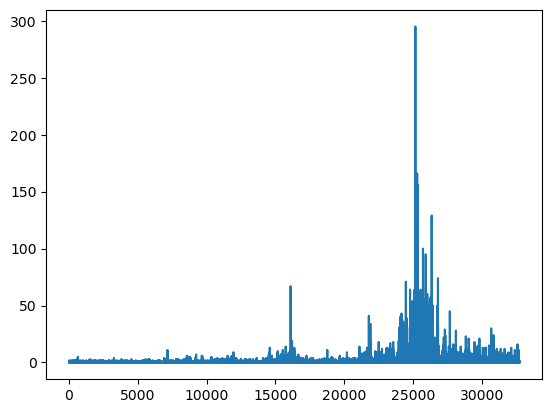

In [50]:
print(len(cts)) #have to wrap it with the nan to num
import matplotlib.pyplot as plt
plt.plot(cts) #yeah looks about right, see like 2 potential peaks

In [52]:
print(counts)
print(np.log(1+np.sum(cts))) #basically identical since it's so large!

10.196604827477849
10.196642123515149


In [54]:
#test the dataset

import src.dataloaders.datasets.profile_atac_long as profile_atac_long
dataset = profile_atac_long.ProfileATACLong('train', 32768, 20000, tokenizer_name = 'char', rc_aug = True, jitter = 900)
out = dataset[0]

TypeError: new(): data must be a sequence (got numpy.float64)

In [55]:
#let's figure out the issue
peak = dataset.peak_coords[idx]
chrom = peak[0]
center = int(peak[1])
offset = dataset.max_length//2 + dataset.jitter
seq = dataset.genome[chrom][center-offset:center+offset].seq.upper()
one_hot_seq = dna_to_one_hot([seq])[0]
offset = dataset.cts_max_length//2 + dataset.jitter
cts = np.nan_to_num(dataset.cts_bw.values(chrom, center-offset, center+offset))
counts = np.log(1+np.sum(cts))

In [56]:
seq = dataset.tokenizer(seq,
    add_special_tokens=True if dataset.add_eos else False,  # this is what controls adding eos
    padding="max_length",
    max_length=dataset.max_length,
    truncation=True,
)

In [58]:
seq = seq['input_ids']

In [59]:
seq

[10,
 7,
 9,
 7,
 8,
 7,
 9,
 9,
 7,
 10,
 9,
 9,
 10,
 8,
 10,
 8,
 7,
 7,
 10,
 10,
 10,
 8,
 10,
 10,
 9,
 7,
 8,
 8,
 10,
 10,
 9,
 10,
 9,
 7,
 10,
 8,
 10,
 9,
 8,
 8,
 10,
 9,
 8,
 8,
 10,
 8,
 7,
 9,
 8,
 8,
 10,
 8,
 8,
 8,
 7,
 7,
 7,
 9,
 10,
 9,
 8,
 10,
 9,
 9,
 9,
 7,
 10,
 10,
 7,
 8,
 7,
 9,
 9,
 8,
 9,
 10,
 9,
 7,
 9,
 8,
 8,
 7,
 8,
 8,
 10,
 8,
 8,
 8,
 8,
 9,
 9,
 8,
 8,
 7,
 7,
 7,
 8,
 7,
 10,
 10,
 10,
 10,
 7,
 10,
 10,
 10,
 10,
 7,
 7,
 7,
 10,
 9,
 7,
 7,
 8,
 9,
 8,
 8,
 10,
 10,
 10,
 10,
 7,
 10,
 10,
 10,
 7,
 7,
 9,
 7,
 7,
 10,
 7,
 10,
 9,
 7,
 7,
 7,
 7,
 7,
 8,
 10,
 10,
 7,
 9,
 7,
 10,
 8,
 10,
 9,
 10,
 9,
 7,
 8,
 7,
 10,
 7,
 7,
 7,
 9,
 7,
 8,
 8,
 7,
 9,
 8,
 8,
 10,
 9,
 9,
 8,
 8,
 7,
 7,
 8,
 7,
 10,
 9,
 7,
 10,
 9,
 7,
 7,
 9,
 8,
 8,
 8,
 8,
 7,
 10,
 8,
 10,
 8,
 10,
 7,
 8,
 10,
 7,
 7,
 7,
 7,
 7,
 10,
 7,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 10,
 10,
 7,
 9,
 8,
 8,
 7,
 9,
 9,
 8,
 7,
 10,
 9,
 9,
 10,
 9,
 9,
 8,
 9,
 8,
 9,
 8,
 7,
 8,
 

In [62]:
start = np.random.choice(range(dataset.jitter*2+1))
print(start)
seq = seq[start:start+dataset.max_length]
cts = cts[start:start+dataset.max_length]


783


In [63]:
print(seq)

[9, 10, 9, 10, 7, 9, 9, 8, 10, 9, 10, 7, 7, 10, 9, 10, 7, 7, 9, 7, 7, 10, 10, 8, 8, 7, 7, 9, 10, 8, 10, 9, 9, 7, 10, 7, 7, 7, 7, 9, 10, 8, 10, 7, 10, 8, 8, 10, 7, 10, 7, 7, 9, 7, 9, 8, 7, 8, 7, 7, 7, 9, 7, 10, 7, 9, 7, 10, 9, 10, 8, 8, 7, 9, 9, 7, 10, 10, 7, 10, 10, 9, 10, 10, 10, 8, 7, 9, 8, 8, 7, 10, 10, 9, 9, 10, 10, 7, 8, 8, 7, 10, 10, 8, 10, 7, 7, 7, 7, 7, 7, 8, 7, 9, 7, 7, 7, 7, 8, 7, 10, 10, 10, 7, 9, 7, 9, 9, 9, 8, 10, 9, 9, 10, 10, 7, 7, 7, 10, 7, 7, 7, 10, 10, 7, 10, 8, 7, 9, 10, 7, 10, 7, 7, 10, 7, 8, 7, 10, 7, 9, 10, 7, 10, 7, 9, 10, 9, 7, 10, 10, 7, 7, 9, 7, 10, 8, 7, 10, 9, 10, 10, 8, 10, 8, 10, 8, 8, 10, 9, 7, 9, 8, 8, 8, 7, 10, 9, 7, 10, 10, 10, 7, 8, 8, 7, 9, 10, 7, 9, 10, 9, 10, 9, 7, 9, 8, 10, 10, 9, 9, 9, 8, 7, 7, 9, 10, 10, 7, 10, 9, 10, 7, 7, 8, 8, 10, 8, 10, 8, 10, 9, 10, 9, 8, 10, 10, 8, 7, 9, 10, 10, 10, 8, 10, 10, 8, 7, 10, 8, 10, 7, 10, 7, 7, 7, 7, 10, 7, 9, 7, 8, 7, 10, 8, 10, 7, 8, 8, 10, 8, 7, 10, 7, 9, 10, 9, 10, 10, 9, 10, 7, 10, 9, 10, 9, 7, 9, 10, 10, 

In [64]:
print(cts)

[0. 0. 0. ... 1. 2. 0.]


In [66]:
import torch
torch.LongTensor(seq)

tensor([ 9, 10,  9,  ..., 10,  9, 10])

In [68]:
one_hot_seq

array([[0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       ...,
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0]], dtype=int8)

In [1]:
#let's try it again after some changes so it works?
import src.dataloaders.datasets.profile_atac_long as profile_atac_long
dataset = profile_atac_long.ProfileATACLong('train', 32768, tokenizer_name = 'char', rc_aug = True, jitter = 900)
out = dataset[0]

In [2]:
len(out)

2

In [2]:
print(out[0][0].shape,out[0][0]) #this is a single thing
print(out[1][0].shape,out[1][0]) #wait why is this a different size... oh tokenizer, did the cropping before tokenizer now
print(out[1][1].shape,out[1][1]) #this is a single thing

torch.Size([32768]) tensor([ 7, 10,  7,  ...,  7,  7,  8])
torch.Size([32768]) tensor([0., 0., 0.,  ..., 0., 0., 0.])
torch.Size([1]) tensor([10.1981])


In [3]:
out[0][0] #no eos at the beginning or the end!

tensor([ 7, 10,  7,  ...,  7,  7,  8])

In [4]:
import torch
import numpy as np
print(torch.FloatTensor([np.log(3)])) #see this works
torch.FloatTensor(np.log(3))

tensor([1.0986])


TypeError: new(): data must be a sequence (got numpy.float64)

In [5]:
len(dataset)

220311

In [4]:
#now we can test how long it takes to load in the whole dataset
for i in range(1000):
    out = dataset[i]
    if i % 1000 == 0:
        print(i)
#it's quite slow, 1000 every 20 or so seconds? i am not sure we can really speed it up tho

0


In [5]:
#took like 20 seconds
dataset = profile_atac_long.ProfileATACLong('train', 32768, tokenizer_name = 'char', rc_aug = True, jitter = 9000)
for i in range(1000):
    out = dataset[i] #jitter doesn't slow it down as we obviouslyl expect

In [6]:
dataset = profile_atac_long.ProfileATACLong('train', 1000000, tokenizer_name = 'char', rc_aug = True, jitter = 90000)
for i in range(1000):
    out = dataset[i] #but longer context does! 1000 takes 4 min for 386!!
    

KeyboardInterrupt: 

In [11]:
#let's try the steps to see how fast it is
offset = 500000
chrom = 'chr1'
center = 1000000 #this is quite quick
for i in range(1000):
    seq = dataset.genome[chrom][center-offset:center+offset].seq.upper()

In [17]:
import numpy as np
from tqdm import tqdm
for i in tqdm(range(1000)): #this is a bit slower but it's still quite quick!
    dna_to_one_hot([seq])[0]

100%|██████████| 1000/1000 [00:42<00:00, 23.47it/s]


In [19]:
for i in tqdm(range(1000)):
    cts = np.nan_to_num(dataset.cts_bw.values(chrom, center-offset, center+offset))
#this is indeed a major slowdown...
#we need to find a way to speed this up!

100%|██████████| 1000/1000 [01:16<00:00, 13.11it/s]


In [22]:
for i in tqdm(range(1000)):
    temp = dataset.tokenizer(seq,
                add_special_tokens=False,  # this is what controls adding eos
                padding="max_length",
                max_length=dataset.max_length,
                truncation=True,
            )
#ahh indeed this is the slow part!
#this is priority number 1 in terms of needing to speed up!!

 53%|█████▎    | 530/1000 [03:17<02:55,  2.69it/s]


KeyboardInterrupt: 

In [23]:
dataset.tokenizer._vocab_int_to_str

{0: '[CLS]',
 1: '[SEP]',
 2: '[BOS]',
 3: '[MASK]',
 4: '[PAD]',
 5: '[RESERVED]',
 6: '[UNK]',
 7: 'A',
 8: 'C',
 9: 'G',
 10: 'T',
 11: 'N'}

In [33]:
#let's just create a dictionary to tokenize
mapping = {
                    'A': 7,
                    'C': 8,
                    'G': 9,
                    'T': 10,
                    'N': 11
                    }

def tokenize_sequence(sequence, mapping):
    return [mapping.get(nuc, 11) for nuc in sequence]  # Default to '11' for unknown nucleotides
tokenize_sequence('AAAGGGCCCTTTNNNNNT', mapping) #yeah clearly seems correct!

[7, 7, 7, 9, 9, 9, 8, 8, 8, 10, 10, 10, 11, 11, 11, 11, 11, 10]

In [34]:
a = tokenize_sequence(1_000_000*'A',mapping) #instant even for 1 million!

In [36]:
import torch
torch.LongTensor(a)

tensor([7, 7, 7,  ..., 7, 7, 7])

In [1]:
#now let's try it again
from tqdm import tqdm
import src.dataloaders.datasets.profile_atac_long as profile_atac_long
dataset = profile_atac_long.ProfileATACLong('train', 32768, tokenizer_name = 'char', rc_aug = True, jitter = 900)
for i in tqdm(range(1000)):
    out = dataset[i] #this is quite quick now! 7 seconds for 30k

100%|██████████| 1000/1000 [00:07<00:00, 130.72it/s]


In [2]:
dataset = profile_atac_long.ProfileATACLong('train', 1000000, tokenizer_name = 'char', rc_aug = True, jitter = 90000)
for i in tqdm(range(1000)):
    out = dataset[i] #this is still quite slow, like several minutes still, but much faster than before!

 12%|█▏        | 121/1000 [00:30<03:38,  4.02it/s]


KeyboardInterrupt: 

In [4]:
seq = 1_000_000*'A'
string_complement_map = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'a': 't', 'c': 'g', 'g': 'c', 't': 'a'}
def string_reverse_complement(seq):
    rev_comp = ''
    for base in seq[::-1]:
        if base in string_complement_map:
            rev_comp += string_complement_map[base]
        # if bp not complement map, use the same bp
        else:
            rev_comp += base
    return rev_comp
for i in tqdm(range(1000)):
    string_reverse_complement(seq)
#not a major slowdown, but could be quite a bit quicker if we do numpy array

  9%|▉         | 94/1000 [00:07<01:08, 13.22it/s]


KeyboardInterrupt: 

In [11]:
mapping = {
                    'A': 7,
                    'C': 8,
                    'G': 9,
                    'T': 10,
                    'N': 11
                    }
seq = 'ACCCACGTTCGTTTTTTGGGCCCAAAAAAAAAAAA'*100000
print(len(seq))
tokenized = [mapping.get(nuc, 11) for nuc in seq]
print(len(tokenized))
#now let's try to RC it
RC_mapping = {7: 10, 8: 9, 9: 8, 10: 7, 11: 11}
def tokenized_rc(tokenized):
    return [RC_mapping.get(nuc, 11) for nuc in tokenized[::-1]]
tokenized_rc(tokenized)
print(tokenized[:10])
print(tokenized_rc(tokenized)[-10:]) #clearly if you flip it it's complement, so yees seems to be working niceley!

3500000
3500000
[7, 8, 8, 8, 7, 8, 9, 10, 10, 8]
[9, 7, 7, 8, 9, 10, 9, 9, 9, 10]


In [13]:
seq = 'ACCCACGTTCGTTTTTTGGGCCCAAAAAAAAAAAA'
print(len(seq))

35


In [14]:
#let's test the speed of this mapping


 10%|█         | 104/1000 [00:08<01:09, 12.95it/s]


KeyboardInterrupt: 

In [17]:
import cProfile

def main():
    seq = 'A' * 1_000_000
    tokenized = [mapping.get(nuc, 11) for nuc in seq]
    a = tokenized_rc(tokenized)

cProfile.run('main()')


         2000007 function calls in 0.391 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.386    0.386 1580664104.py:3(main)
        1    0.138    0.138    0.190    0.190 1580664104.py:5(<listcomp>)
        1    0.004    0.004    0.196    0.196 3760089249.py:14(tokenized_rc)
        1    0.139    0.139    0.193    0.193 3760089249.py:15(<listcomp>)
        1    0.005    0.005    0.391    0.391 <string>:1(<module>)
        1    0.000    0.000    0.391    0.391 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
  2000000    0.105    0.000    0.105    0.000 {method 'get' of 'dict' objects}




In [ ]:
#let's try calling this with C

import subprocess
c_program = '/data/leslie/sarthak/hyena/hyena-dna/src/dataloaders/datasets/reverse_complement'
input_sequence = 'ACCCGGGTN' #huh ignores this last index for some reason...
process = subprocess.Popen(
    c_program,
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)
stdout, stderr = process.communicate(input=input_sequence.encode())

print(stdout.decode())


ACCCGGGT



In [6]:
#let's try calling this with C

import subprocess
c_program = '/data/leslie/sarthak/hyena/hyena-dna/src/dataloaders/datasets/reverse_complement'
input_sequence = 'ACNNPP' #huh ignores this last index for some reason and doesn't map it
process = subprocess.Popen(
    c_program,
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)
stdout, stderr = process.communicate(input=input_sequence.encode())

print(stdout.decode())


PNNGT



In [21]:
#alright let's try this with a huge thing
from tqdm import tqdm
for i in tqdm(range(1000)):
    input_sequence = 'A'*1_000_000
    process = subprocess.Popen(
        c_program,
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
    )
    stdout, stderr = process.communicate(input=input_sequence.encode())
    a = stdout.decode()
    # print(stdout.decode())
#very fast reverse complement!

100%|██████████| 1000/1000 [00:09<00:00, 105.53it/s]


In [22]:
print(a[:100])

TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


In [ ]:
#so this is how we could do it with multiple workders

import subprocess
import torch
from torch.utils.data import DataLoader, Dataset
from multiprocessing import Pool

# Define the path to the compiled C program
C_PROGRAM = "./reverse_complement"

class GenomeDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx]

def call_c_program(sequence):
    process = subprocess.Popen(
        C_PROGRAM,
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
    )
    stdout, stderr = process.communicate(input=sequence.encode())
    
    if stderr:
        raise RuntimeError(stderr.decode())
    
    return stdout.decode().strip()

def worker_function(sequence):
    return call_c_program(sequence)

def collate_fn(batch):
    with Pool(len(batch)) as pool:
        results = pool.map(worker_function, batch)
    return results

# Example input sequences
sequences = ['A' * 1_000_000 for _ in range(100)]  # 100 sequences, each 1 million 'A's

# Create dataset and dataloader
dataset = GenomeDataset(sequences)
dataloader = DataLoader(dataset, batch_size=4, num_workers=4, collate_fn=collate_fn)

# Iterate over dataloader
for batch in dataloader:
    for result in batch:
        print(result[:50])  # Print the first 50 characters of each result to check


In [28]:
#we also did a tokenize for C

import subprocess
c_program = '/data/leslie/sarthak/hyena/hyena-dna/src/dataloaders/datasets/tokenize'
input_sequence = 'ACGTACGTACGTACGTN' #huh ignores this last index for some reason and doesn't map it
process = subprocess.Popen(
    c_program,
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)
stdout, stderr = process.communicate(input=input_sequence.encode())

print(stdout.decode())
#oh this doesn't work because T outputs 2, that's actualy quite annoying!

0123012301230123



In [32]:
#turn every element of the string to a list
out = [int(char)+7 for char in stdout.decode()[:-1]]
print(out)

[7, 8, 9, 10, 7, 8, 9, 10, 7, 8, 9, 10, 7, 8, 9, 10]


In [39]:
seq = 'A'*1_000_000
process = subprocess.Popen(
    c_program,
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)
stdout, stderr = process.communicate(input=seq.encode())
tokenized = [int(char)+7 for char in stdout.decode()[:-1]]

In [43]:
len(tokenized)

999999

In [42]:
#now try with the further speedups
#let's compare the RC for example
RC_mapping = {7: 10, 8: 9, 9: 8, 10: 7, 11: 11}
def tokenized_rc(tokenized):
    return [RC_mapping.get(nuc, 11) for nuc in tokenized[::-1]]
from tqdm import tqdm
for i in tqdm(range(1000)):
    tokenized_rc(tokenized)

100%|██████████| 1000/1000 [00:45<00:00, 21.85it/s]


In [48]:

seq = 'A'*10+'N' #need this N so that it's correct
    #first RC
c_program = '/data/leslie/sarthak/hyena/hyena-dna/src/dataloaders/datasets/reverse_complement'
process = subprocess.Popen(
    c_program,
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)
stdout, stderr = process.communicate(input=seq.encode())
print(stdout.decode(), len(stdout.decode().strip()))

TTTTTTTTTT
 10


In [53]:
#let's combine both together and see how fast it is
for i in tqdm(range(1000)):
    seq = 'A'*1_000_000
    #first RC
    c_program = '/data/leslie/sarthak/hyena/hyena-dna/src/dataloaders/datasets/reverse_complement'
    process = subprocess.Popen(
        c_program,
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
    )
    stdout, stderr = process.communicate(input=seq.encode())
    a = stdout.decode().strip()
    c_program = '/data/leslie/sarthak/hyena/hyena-dna/src/dataloaders/datasets/tokenize'
    process2 = subprocess.Popen(
        c_program,
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
    )
    stdout, stderr = process2.communicate(input=seq.encode())
    tokenized = [int(char)+7 for char in stdout.decode()[:-1]] #this part is a bit slow but it's not the slow part, about 50% of the slowdown

#lmao we jsut wasted this time, it's very slow!

 14%|█▍        | 141/1000 [00:17<01:48,  7.89it/s]


KeyboardInterrupt: 

In [54]:
#so this seems to be the slow part rn
#first let's just solve the tokenizer and see if we are indeed faster than the hugging face tokenizer
mapping = {
                    'A': 7,
                    'C': 8,
                    'G': 9,
                    'T': 10,
                    'N': 11
                    }
seq = 'A'*1_000_000
for i in tqdm(range(1000)):
    tokenized = [mapping.get(nuc, 11) for nuc in seq]
#it is indeed decently fast

100%|██████████| 1000/1000 [00:43<00:00, 22.78it/s]


In [58]:
#and the C implementation
seq = 'A'*1_000_000+'N'
for i in tqdm(range(1000)):
    c_program = '/data/leslie/sarthak/hyena/hyena-dna/src/dataloaders/datasets/tokenize'
    process = subprocess.Popen(
        c_program,
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
    )
    stdout, stderr = process.communicate(input=seq.encode())
    tokenized = [int(char)+7 for char in stdout.decode()[:-1]]
#ok so this tokenizer is much much slower

  7%|▋         | 74/1000 [00:20<04:20,  3.56it/s]


KeyboardInterrupt: 

In [59]:
#let's look at the C implementation of the RC
seq = 'A'*1_000_000+'N'
for i in tqdm(range(1000)):
    c_program = '/data/leslie/sarthak/hyena/hyena-dna/src/dataloaders/datasets/reverse_complement'
    process = subprocess.Popen(
        c_program,
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
    )
    stdout, stderr = process.communicate(input=seq.encode())
    a = stdout.decode().strip()
#this is decently fast

100%|██████████| 1000/1000 [00:18<00:00, 52.71it/s]


In [60]:
#and let's make a python implementation
seq = 'A'*1_000_000
string_complement_map = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'a': 't', 'c': 'g', 'g': 'c', 't': 'a'}
def string_reverse_complement(seq):
    rev_comp = ''
    for base in seq[::-1]:
        if base in string_complement_map:
            rev_comp += string_complement_map[base]
        # if bp not complement map, use the same bp
        else:
            rev_comp += base
    return rev_comp
for i in tqdm(range(1000)):
    string_reverse_complement(seq) #this is much slower than the C version

 10%|▉         | 95/1000 [00:10<01:43,  8.75it/s]


KeyboardInterrupt: 

In [64]:
#what about using my method
seq = 'A'*1_000_000
RCmap = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'N': 'N'}
for i in tqdm(range(1000)):
    a = [RCmap.get(nuc, 'N') for nuc in seq] #faster than their implementation, but it also does make it a list. 44 seconds without joining
    #and turn it back into a string
    a = ''.join(a) #ok basically the same time with this, so it's not the joining that's slow
    
#let's use the c implementation for RC?

100%|██████████| 1000/1000 [00:47<00:00, 21.14it/s]


In [65]:
#now let's try this fast seqpy approach
import os
cwd = os.getcwd()
dir_path = os.path.dirname(os.path.realpath(__file__))
os.chdir(dir_path)
print(subprocess.check_output(['python','setup.py', 'build_ext', '-i']))
os.chdir(cwd)
import seqpy

NameError: name '__file__' is not defined

In [67]:
#not worth the hassle, for now we will just let the training be slower, especially with a large number of workers, it's all good!
#lots of overlap likely lmfao!
#can use the C RC if we really want to

#the other crazy option is to have the entire RC of the human chromosome... could just access that and reverse it..
#let's test what I have with some random sequences

seq = 'AAAGGGACGTTTTTTT'
tokenizer_mapping = {'A': 7,'C': 8,'G': 9,'T': 10,'N': 11}
RC_mapping = {7: 10, 8: 9, 9: 8, 10: 7, 11: 11}
seq2 = [tokenizer_mapping.get(nuc, 11) for nuc in seq]
print(seq2)
seq3 = [RC_mapping.get(nuc, 11) for nuc in seq2[::-1]] #i'm pretty sure this works
print(seq3)

[7, 7, 7, 9, 9, 9, 7, 8, 9, 10, 10, 10, 10, 10, 10, 10]
[7, 7, 7, 7, 7, 7, 7, 8, 9, 10, 8, 8, 8, 10, 10, 10]


In [68]:
#combined let's see the speed
for i in tqdm(range(1000)):
    seq = 'A'*1_000_000
    seq2 = [tokenizer_mapping.get(nuc, 11) for nuc in seq]
    seq3 = [RC_mapping.get(nuc, 11) for nuc in seq2[::-1]]
    #so 1000 sequences does indeed take a while... but it's not the worst?

100%|██████████| 1000/1000 [01:31<00:00, 10.96it/s]


In [74]:
#what about storing whole reference genome

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

def reverse_complement_fasta(input_fasta, output_fasta):
    # Read the input FASTA file
    records = SeqIO.parse(input_fasta, "fasta")
    
    # Create a list to hold the reverse complement records
    rev_comp_records = []
    
    for record in tqdm(records, total=195):
        # Compute the reverse complement
        rev_comp_seq = record.seq.reverse_complement()
        
        # Create a new SeqRecord with the reverse complement sequence
        rev_comp_record = SeqRecord(
            rev_comp_seq,
            id=record.id,
            name=record.name,
            description=f"reverse complement of {record.description}"
        )
        
        # Append the reverse complement record to the list
        rev_comp_records.append(rev_comp_record)
    
    # Write the reverse complement records to the output FASTA file
    SeqIO.write(rev_comp_records, output_fasta, "fasta")

# Define the input and output FASTA file paths
input_fasta = "/data/leslie/sarthak/data/chrombpnet_test/hg38.fa"
output_fasta = "/data/leslie/sarthak/data/chrombpnet_test/hg38_rc.fa"

# Run the reverse complement function
reverse_complement_fasta(input_fasta, output_fasta)
#there's no way this is this fast

  0%|          | 0/195 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [72]:
def count_records(fasta_file):
    # Count the number of records in the FASTA file
    with open(fasta_file, "r") as handle:
        return sum(1 for _ in SeqIO.parse(handle, "fasta"))
count_records(input_fasta) #this is the number of records or reads, this is what we put into the total for tqdm
#195

195

In [75]:
#let's test if my reverse complement is indeed the case
import pyfaidx
genome = pyfaidx.Fasta(input_fasta)
genome_rc = pyfaidx.Fasta(output_fasta)
#let's test a random sequence
genome['chr1'][100000:100010].seq

'ACTAAGCACA'

In [80]:
#now let's find the corresponding elements for the RC
genome_rc['chr1'][248956422-100010:248956422-100000].seq

#this is indeed the reverse complement

'TGTGCTTAGT'

In [81]:
#let's try a larger sequence
genome['chr1'][100000:100050].seq


'ACTAAGCACACAGAGAATAATGTCTAGAATCTGAGTGCCATGTTATCAAA'

In [85]:
a = genome_rc['chr1'][248956422-100050:248956422-100000]
a.seq

'TTTGATAACATGGCACTCAGATTCTAGACATTATTCTCTGTGTGCTTAGT'

In [91]:
#do the rc of this sequence a
string_complement_map = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'a': 't', 'c': 'g', 'g': 'c', 't': 'a'}

def string_reverse_complement(seq):
    rev_comp = ''
    for base in seq[::-1]:
        if base in string_complement_map:
            rev_comp += string_complement_map[base]
        # if bp not complement map, use the same bp
        else:
            rev_comp += base
    return rev_comp

string_reverse_complement(a.seq)
#copy paste from above
#ACTAAGCACACAGAGAATAATGTCTAGAATCTGAGTGCCATGTTATCAAA
#ACTAAGCACACAGAGAATAATGTCTAGAATCTGAGTGCCATGTTATCAAA
#perfect match!!

'ACTAAGCACACAGAGAATAATGTCTAGAATCTGAGTGCCATGTTATCAAA'

In [14]:
#now let's test this reverse complement stuff
import numpy as np
import pyfaidx
input_fasta = "/data/leslie/sarthak/data/chrombpnet_test/hg38.fa"
output_fasta = "/data/leslie/sarthak/data/chrombpnet_test/hg38_rc.fa"
genome = pyfaidx.Fasta(input_fasta)
genome_rc = pyfaidx.Fasta(output_fasta)

string_complement_map = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'a': 't', 'c': 'g', 'g': 'c', 't': 'a'}

def string_reverse_complement(seq):
    rev_comp = ''
    for base in seq[::-1]:
        if base in string_complement_map:
            rev_comp += string_complement_map[base]
        # if bp not complement map, use the same bp
        else:
            rev_comp += base
    return rev_comp

for i in range(1000):
    #get a random chromosome
    chrom = np.random.choice(['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22','chrX','chrY'])
    start = np.random.choice(range(1000000))
    end = int(start + 1000)
    seq = genome[chrom][start:end].seq
    chrom_len = len(genome[chrom])
    seq_rc = genome_rc[chrom][chrom_len-end:chrom_len-start].seq
    if seq != string_reverse_complement(seq_rc):
        print('error')
        break

In [15]:
print(len(seq), len(seq_rc))

1000 1000


In [11]:
#huh what's the error
print(seq[:10])
print(seq_rc[-10:])

CTCAAACAAC
GTTGTTTGAG


In [16]:
#so it seems fine for lengths of 1000, but at 1 million it causes issues

for i in range(1000):
    #get a random chromosome
    chrom = np.random.choice(['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22','chrX','chrY'])
    start = np.random.choice(range(1000000))
    end = int(start + 1e6)
    seq = genome[chrom][start:end].seq
    chrom_len = len(genome[chrom])
    seq_rc = genome_rc[chrom][chrom_len-end:chrom_len-start].seq
    if seq != string_reverse_complement(seq_rc):
        print('error')
        break

error


In [18]:
print(seq[:10], seq[-10:]) #so not at the edge, unclear where the issue is
print(seq_rc[:10], seq_rc[-10:])

TCGCTCTTTC GGAGCTTGCA
TGCAAGCTCC GAAAGAGCGA


In [20]:
temp = string_reverse_complement(seq_rc)
for i in range(len(seq)):
    if seq[i] != temp[i]:
        print(seq[i], temp[i], i)
        break

R Y 100916


In [22]:
#wtf is R and Y??
print(start, chrom)

388457 chr17


In [26]:
genome['chr17'][start+100915:start+100926].seq

'GRCCCTCGCTC'

In [27]:
for i in range(len(seq)):
    if seq[i] != temp[i]:
        print(seq[i], temp[i], i)
#just this one issue

R Y 100916


In [30]:
#let's test the speed
from tqdm import tqdm
for i in tqdm(range(1000)):
    #the random stuff actually slows it down the most, but if we have our peaks already will be quite fast!
    #this is good!
    chrom = 'chr1'
    start = 1000000
    end = int(start + 1e6)
    seq = genome[chrom][start:end].seq
    chrom_len = len(genome[chrom])
    seq_rc = genome_rc[chrom][chrom_len-end:chrom_len-start].seq

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 286.51it/s]


In [32]:
#now let's try it with the actual dataset
import sys
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
import src.dataloaders.datasets.profile_atac_long as profile_atac_long
dataset = profile_atac_long.ProfileATACLong('train', 32768, tokenizer_name = 'char', rc_aug = True, jitter = 0)

In [40]:
out1 = dataset[0]
out2 = dataset[0] #keep trying until one is the rc of the other
print(out1)
print(out2)

((tensor([10,  7, 10,  ..., 10,  9, 10]), None), (tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([10.1966])))
((tensor([ 7,  8,  7,  ...,  7, 10,  7]), None), (tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([10.1966])))


In [41]:
out1[0][0].shape

torch.Size([32768])

In [44]:
mapping = {7:10, 8:9, 9:8, 10:7, 11:11}
rcd = []
for i in out1[0][0]:
    rcd.append(mapping[i.item()])
print(len(rcd))

32768


In [47]:
import torch
temp = torch.tensor(rcd[::-1])

In [48]:
torch.allclose(temp, out2[0][0])

True

In [49]:
#I guess we can just assume it works, but let's see how fast the dataset is
from tqdm import tqdm
for i in tqdm(range(1000)): #quite quick for 32k, but let's try 1 million
    out = dataset[i]

100%|██████████| 1000/1000 [00:12<00:00, 83.27it/s]


In [52]:
dataset = profile_atac_long.ProfileATACLong('train', 1_000_000, tokenizer_name = 'char', rc_aug = True, jitter = 0)

In [53]:
from tqdm import tqdm
for i in tqdm(range(1000)): #and it's back to very slow...
    out = dataset[i]

 18%|█▊        | 178/1000 [00:59<04:32,  3.01it/s]


KeyboardInterrupt: 

In [55]:
#I think the next slowdown is the bigwig file
test = dataset.cts_bw.values('chr1', 1000000, 1000000*2)

In [56]:
for i in tqdm(range(1000)): #and it's back to very slow...
    dataset.cts_bw.values('chr1', 1000000, 1000000*2)
#a little bit slow, but 4 times faster, so 25% of the total speed...

 34%|███▎      | 337/1000 [00:24<00:49, 13.52it/s]


KeyboardInterrupt: 

In [57]:
from random import random
idx = 0
def coin_flip():
    return random() > 0.5

#now use the profiler to determine slowdown
import cProfile
def main():
    peak = dataset.peak_coords[idx]
    chrom = peak[0]
    center = int(peak[1])
    offset = dataset.max_length//2 + dataset.jitter
    cts = np.nan_to_num(dataset.cts_bw.values(chrom, center-offset, center+offset))
    #first we see if we do RC, if it is RC get it from the other file
    if dataset.rc_aug and coin_flip():
        # seq = [dataset.RC_mapping.get(nuc, 11) for nuc in seq[::-1]]
        lenchrom = len(dataset.genome[chrom])
        seq = dataset.genome_rc[chrom][lenchrom-(center+offset):lenchrom-(center-offset)].seq.upper()
        cts = cts[::-1]
    else:
        seq = dataset.genome[chrom][center-offset:center+offset].seq.upper()
    if dataset.one_hot:
        one_hot_seq = dna_to_one_hot([seq])[0]
    else:
        one_hot_seq = None
    # offset = dataset.max_length//2 + dataset.jitter



    if dataset.jitter:
        start = np.random.choice(range(dataset.jitter*2+1)) #because range excludes the last one
        seq = seq[start:start+dataset.max_length]
        cts = cts[start:start+dataset.max_length]
        if dataset.one_hot:
            one_hot_seq = one_hot_seq[start:start+dataset.max_length]

    #just do a manual mapping
    seq = [dataset.tokenizer_mapping.get(nuc, 11) for nuc in seq]
    #RC after tokenization
    counts = np.log(1+np.sum(cts))
    seq = torch.LongTensor(seq)
    # print(counts)
    counts = torch.FloatTensor([counts])
    cts = torch.FloatTensor(cts.copy())
    if dataset.one_hot:
        one_hot_seq = torch.FloatTensor(one_hot_seq.copy()) #is a numpy array so can do .copy()

cProfile.run('main()')

         1000072 function calls (1000071 primitive calls) in 0.507 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 2592476886.py:3(coin_flip)
        1    0.225    0.225    0.310    0.310 2592476886.py:38(<listcomp>)
        1    0.079    0.079    0.507    0.507 2592476886.py:8(main)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1207(_handle_fromlist)
        1    0.000    0.000    0.507    0.507 <string>:1(<module>)
        2    0.000    0.000    0.000    0.000 __init__.py:1117(__getitem__)
        1    0.000    0.000    0.002    0.002 __init__.py:1136(get_seq)
        1    0.000    0.000    0.000    0.000 __init__.py:203(__len__)
        1    0.000    0.000    0.000    0.000 __init__.py:523(__contains__)
        1    0.000    0.000    0.002    0.002 __init__.py:714(fetch)
        1    0.000    0.000    0.002    0.002 __init__.py:725(from_file)
   

In [58]:
#the slowdown is the bigwig and the list comprehension and dictionary parts, let's figure out howw to speed up the gathering of the data
#the most obvious method is to just make a new reference genome which is the tokenized version of it already

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from tqdm import tqdm

# Define the mapping
token_mapping = {
    'A': 7,
    'C': 8,
    'G': 9,
    'T': 10
}

def tokenize_sequence(sequence):
    # Tokenize the sequence using the mapping, defaulting to 11 for any non-ACGT characters
    return [token_mapping.get(base, 11) for base in sequence]

def tokenize_fasta(input_fasta, output_fasta):
    # Read the input FASTA file
    records = list(SeqIO.parse(input_fasta, "fasta"))
    
    # Process each record with progress tracking
    tokenized_records = []
    for record in tqdm(records, desc="Tokenizing sequences"):
        tokenized_seq = tokenize_sequence(record.seq)
        
        # Create a new SeqRecord with the tokenized sequence
        tokenized_record = SeqRecord(
            Seq(' '.join(map(str, tokenized_seq))),  # Join integers as space-separated string
            id=record.id,
            name=record.name,
            description=record.description
        )
        
        # Append the tokenized record to the list
        tokenized_records.append(tokenized_record)
    
    # Write the tokenized records to the output FASTA file
    SeqIO.write(tokenized_records, output_fasta, "fasta")

# Define the input and output FASTA file paths
input_fasta = "/data/leslie/sarthak/data/chrombpnet_test/hg38.fa"
output_fasta = "/data/leslie/sarthak/data/chrombpnet_test/hg38_tokenized.fa"

# Run the tokenization function
tokenize_fasta(input_fasta, output_fasta)


Tokenizing sequences:   2%|▏         | 4/195 [03:53<3:05:54, 58.40s/it]


KeyboardInterrupt: 

In [60]:
#that stores it in an inefficient way, let's try 2 things to see the speed
#first is to see hwo fast you can convert a string of 0,1,2,3 into a torch tensor
test_seq = '0123'*250000
for i in tqdm(range(1000)): #it's also quite slow...
    a = torch.LongTensor([int(char) for char in test_seq])


  8%|▊         | 76/1000 [00:14<02:54,  5.28it/s]


KeyboardInterrupt: 

In [ ]:
#the best alternative then seems to be to store the data in hdf5 format with h5py, but that will be a bit complicated, could use something like this

import h5py
from Bio import SeqIO
from tqdm import tqdm
import numpy as np

# Define the mapping
token_mapping = {
    'A': 7,
    'C': 8,
    'G': 9,
    'T': 10
}

def tokenize_sequence(sequence):
    # Tokenize the sequence using the mapping, defaulting to 11 for any non-ACGT characters
    return np.array([token_mapping.get(base, 11) for base in sequence], dtype=np.int32)

def tokenize_fasta(input_fasta, output_file):
    # Read the input FASTA file
    records = list(SeqIO.parse(input_fasta, "fasta"))
    
    # Create an HDF5 file
    with h5py.File(output_file, 'w') as h5f:
        # Process each record with progress tracking
        for record in tqdm(records, desc="Tokenizing sequences"):
            tokenized_seq = tokenize_sequence(record.seq)
            
            # Create a dataset for each sequence
            h5f.create_dataset(record.id, data=tokenized_seq)

def load_tokenized_data(file_path):
    # Load the tokenized sequences from the HDF5 file
    with h5py.File(file_path, 'r') as h5f:
        tokenized_records = {name: np.array(dataset) for name, dataset in h5f.items()}
    return tokenized_records

# Define the input and output file paths
input_fasta = "input_genome.fasta"
output_file = "tokenized_genome.h5"

# Run the tokenization function
tokenize_fasta(input_fasta, output_file)

# Load the tokenized data (for demonstration purposes)
tokenized_data = load_tokenized_data(output_file)

# Access a tokenized sequence (for demonstration purposes)
example_key = list(tokenized_data.keys())[0]
print(f"Tokenized sequence for {example_key}: {tokenized_data[example_key][:50]}")


In [62]:
#for now we'll just stick with this slower approach and call it goood, no need to stress that much about it we know this works, let's just test some stuff with it!

#wait, let's try storing it as an npz file where we have each chromosome as one of the keys

import numpy as np
from Bio import SeqIO
from tqdm import tqdm

# Define the mapping
token_mapping = {
    'A': 7,
    'C': 8,
    'G': 9,
    'T': 10
}

def tokenize_sequence(sequence):
    # Tokenize the sequence using the mapping, defaulting to 11 for any non-ACGT characters
    return np.array([token_mapping.get(base, 11) for base in sequence], dtype=np.int32)

def tokenize_fasta(input_fasta, output_file):
    # Read the input FASTA file
    records = list(SeqIO.parse(input_fasta, "fasta"))
    
    # Create a dictionary to hold tokenized sequences
    tokenized_records = {}
    
    # Process each record with progress tracking
    for record in tqdm(records, desc="Tokenizing sequences"):
        tokenized_seq = tokenize_sequence(record.seq)
        
        # Store the tokenized sequence in the dictionary
        tokenized_records[record.id] = tokenized_seq
    
    # Save the tokenized sequences to a .npz file
    np.savez_compressed(output_file, **tokenized_records)

# Define the input and output file paths
input_fasta = "/data/leslie/sarthak/data/chrombpnet_test/hg38.fa"
output_file = "/data/leslie/sarthak/data/chrombpnet_test/hg38_tokenized.npz"

# Run the tokenization function
tokenize_fasta(input_fasta, output_file)


Tokenizing sequences: 100%|██████████| 195/195 [05:16<00:00,  1.63s/it]


In [63]:
#load it in
tokenized_data = np.load(output_file)
print(tokenized_data)

NpzFile '/data/leslie/sarthak/data/chrombpnet_test/hg38_tokenized.npz' with keys: chr1, chr2, chr3, chr4, chr5...


In [65]:
list(tokenized_data.keys()) #lots of these unknown ones, but we only care about the main ones

['chr1',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chr20',
 'chr21',
 'chr22',
 'chrX',
 'chrY',
 'chrM',
 'chr1_KI270706v1_random',
 'chr1_KI270707v1_random',
 'chr1_KI270708v1_random',
 'chr1_KI270709v1_random',
 'chr1_KI270710v1_random',
 'chr1_KI270711v1_random',
 'chr1_KI270712v1_random',
 'chr1_KI270713v1_random',
 'chr1_KI270714v1_random',
 'chr2_KI270715v1_random',
 'chr2_KI270716v1_random',
 'chr3_GL000221v1_random',
 'chr4_GL000008v2_random',
 'chr5_GL000208v1_random',
 'chr9_KI270717v1_random',
 'chr9_KI270718v1_random',
 'chr9_KI270719v1_random',
 'chr9_KI270720v1_random',
 'chr11_KI270721v1_random',
 'chr14_GL000009v2_random',
 'chr14_GL000225v1_random',
 'chr14_KI270722v1_random',
 'chr14_GL000194v1_random',
 'chr14_KI270723v1_random',
 'chr14_KI270724v1_random',
 'chr14_KI270725v1_random',
 'chr14_KI270726v1_random',
 'chr15_KI270727v1_rando

In [68]:
#so let's make a quick test to see if we get the same results
tokenized_data['chr1'].dtype #this is kind of slow for some reason

dtype('int32')

In [69]:
for i in range(10):
    tokenized_data['chr1'].shape

In [70]:
with np.load(output_file, allow_pickle=True) as data:
    # Convert each array in the .npz file to a regular NumPy array
    tokenized_records = {key: np.array(data[key]) for key in data}

In [72]:
#that loads it into memory in an uncompressed form, now we can see how quickly we can access it
#and we see it's near instant, now let's test it! if it works, we save a rc version of this too!!
for i in range(1000):
    tokenized_records['chr1'].shape

In [77]:
for i in tqdm(range(1000)):
    #get a random chromosome
    chrom = np.random.choice(['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22','chrX','chrY'])
    start = np.random.choice(range(1000000))
    end = int(start + 1e6)
    seq = genome[chrom][start:end].seq
    seqnp = tokenized_records[chrom][start:end]
    seq_tokenized = [token_mapping.get(base, 11) for base in seq]
    if not np.allclose(seqnp,seq_tokenized):
        print('error')
        break

  0%|          | 0/1000 [00:00<?, ?it/s]

 27%|██▋       | 272/1000 [01:01<02:43,  4.45it/s]


KeyboardInterrupt: 

In [82]:
#seems good! let's test a random thing
chrom = 'chr17'
start = 1028349
end = start + 1000
seq = genome[chrom][start:end].seq
seqnp = tokenized_records[chrom][start:end]
seq_tokenized = [token_mapping.get(base, 11) for base in seq]
print(seq)
print(seqnp.shape) # a 1d array, I think this works officially!!
print(len(seq_tokenized))

CTGCCTCCCAAAGTGCTGGGATGACAGGCGTGAGCCACCACACTTGGCTAATTTTTGCATTGTTAGTTGAGACGGGGCTTCTCCATGTTGGCCAGGCTGGTCTTGGACTCCTGACATCAGGTGATCCAAGAAAGGGACCTTCTTCTAAGACCATCATGAGCCTGAAGCTTCCCCGAATGGCCCAAGAGGGGCTCTCCACCCCGCCCTTCCTCAGGTAACACCTCTGATCCTCTCTGAAGCAAAGGCAGCAGCTCCCATCACAGAACACGGGACTCACCGTGGGGGTCAGCAGTGCCGGTGTCCAGCTTAAGAGGAGCTCTTTGGAAGTAGGGGATTCTCAGACCCACATGGCTGTGCTTCAGGGCAGAGACAAGGTCACCTGAAGCTGCACTCAATCTCCTTACACCCTGCCGGCTCAGCCTGAGTCCCCACCGCCGGCCAGCATCTGGCCTGGTCTGGGTCAGGAGCGTCTTGGACTTGGTTGCTCTATAAGGGCCTCAACTTCCCCGACAGACAAATGCTTCTGGACCGGCCTCCCTTCAGGCCCTCTTAGCCTCCTCACGGCTCCCACAAGGGGATGCTGCGGGGGCAGGGTGGGGGGGTTCCTCCTTCAGCCCCTTCCCCTCCAAAGCTCAAGCGAGAATCTAGAATTCAGCCCCTTCCCATCCAAAGCTCAACCAAGAATCTAGAAGAGGGAAGGATGGGAGGGAGAGGAAGGCACCGGGCCTGGTCTACTTGAGTGTGATTTGAGGCAAAAAAAAAAAAAAACAAACAGGGAAAAGGAAAGAAAAGTAGAAACGCGAAGTTCAATACCGAGAGCCCTGGCTGAACCCACAAACCCAGATGCCACGTGTCTCCCAGCTAAACACTCGCACAAAAAGCTGACTGCCAAGTCAGGGGCTGGAATGAGGCTTTGGCCCCTGAACTCTCCTCCGGTGACAAGAACAGCCCAACCACAGGGACCCCCGCTGGTACCCAAAGGATCCTCCGTGAGTGTCCC

In [84]:
#in that case, we can create another one for the reverse complement
import numpy as np
from Bio import SeqIO
from tqdm import tqdm

# Define the mapping
token_mapping = {
    'A': 7,
    'C': 8,
    'G': 9,
    'T': 10
}

def tokenize_sequence(sequence):
    # Tokenize the sequence using the mapping, defaulting to 11 for any non-ACGT characters
    return np.array([token_mapping.get(base, 11) for base in sequence], dtype=np.int8) #changed it to int8, no need to go further

def tokenize_fasta(input_fasta, output_file):
    # Read the input FASTA file
    records = list(SeqIO.parse(input_fasta, "fasta"))
    
    # Create a dictionary to hold tokenized sequences
    tokenized_records = {}
    
    # Process each record with progress tracking
    for record in tqdm(records, desc="Tokenizing sequences"):
        tokenized_seq = tokenize_sequence(record.seq)
        
        # Store the tokenized sequence in the dictionary
        tokenized_records[record.id] = tokenized_seq
    
    # Save the tokenized sequences to a .npz file
    np.savez(output_file, **tokenized_records) #also save it out not compressed, it's not even a huge amount of data, it should be fine.

# Define the input and output file paths
input_fasta = "/data/leslie/sarthak/data/chrombpnet_test/hg38_rc.fa"
output_file = "/data/leslie/sarthak/data/chrombpnet_test/hg38_tokenized_rc.npz"

# Run the tokenization function
tokenize_fasta(input_fasta, output_file)

Tokenizing sequences: 100%|██████████| 195/195 [05:22<00:00,  1.66s/it]


In [85]:
tokenized_rc = np.load(output_file)
print(tokenized_rc)

NpzFile '/data/leslie/sarthak/data/chrombpnet_test/hg38_tokenized_rc.npz' with keys: chr1, chr2, chr3, chr4, chr5...


In [87]:
for i in range(10):
    tokenized_rc['chr1'].shape #so here it's not compressed but still it takes a while to load because loads it every time we call it, so in this case let's just 

In [88]:
with np.load(output_file, allow_pickle=True) as data:
    # Convert each array in the .npz file to a regular NumPy array
    tokenized_rc = {key: np.array(data[key]) for key in data} #so this ends up loading much faster, so better to do it this way as int8 and not compressed
    #compressed saves 2 GB (of 3) but it is much much slower! Actuallys aves 2 gb when was int32, now it's int8 tho so it's fine to leave as is I think

In [89]:
input_fasta = "/data/leslie/sarthak/data/chrombpnet_test/hg38.fa" #do it again for the normal one
output_file = "/data/leslie/sarthak/data/chrombpnet_test/hg38_tokenized.npz"
tokenize_fasta(input_fasta, output_file)

Tokenizing sequences: 100%|██████████| 195/195 [05:16<00:00,  1.62s/it]


# final tests to ensure this np array approach works

In [90]:
#first load in both
rc_np = '/data/leslie/sarthak/data/chrombpnet_test/hg38_tokenized_rc.npz'
npz = '/data/leslie/sarthak/data/chrombpnet_test/hg38_tokenized.npz'
with np.load(rc_np, allow_pickle=True) as data:
    tokenized_rc = {key: np.array(data[key]) for key in data}
with np.load(npz, allow_pickle=True) as data:
    tokenized = {key: np.array(data[key]) for key in data}

In [91]:
#now let's also load in the genome
import pyfaidx
input_fasta = "/data/leslie/sarthak/data/chrombpnet_test/hg38.fa"
genome = pyfaidx.Fasta(input_fasta)
rc_fasta = "/data/leslie/sarthak/data/chrombpnet_test/hg38_rc.fa"
genome_rc = pyfaidx.Fasta(rc_fasta)

In [92]:
#now let's call 10000 random sequences
for i in tqdm(range(100)):
    #get a random chromosome
    chrom = np.random.choice(['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22','chrX','chrY'])
    start = np.random.choice(range(1000000))
    end = int(start + 1e6)
    seq = genome[chrom][start:end].seq
    seqnp = tokenized[chrom][start:end]
    seq_tokenized = [token_mapping.get(base, 11) for base in seq]
    if not np.allclose(seqnp,seq_tokenized):
        print('error')
        break

100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


In [93]:
#same for the rc one
for i in tqdm(range(100)):
    #get a random chromosome
    chrom = np.random.choice(['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22','chrX','chrY'])
    start = np.random.choice(range(1000000))
    end = int(start + 1e6)
    seq = genome_rc[chrom][start:end].seq
    seqnp = tokenized_rc[chrom][start:end]
    seq_tokenized = [token_mapping.get(base, 11) for base in seq]
    if not np.allclose(seqnp,seq_tokenized):
        print('error')
        break

100%|██████████| 100/100 [00:26<00:00,  3.77it/s]


In [98]:
#now the final test is ensuring that the RC is indeed the reverse complement
RC_mapping = {7: 10, 8: 9, 9: 8, 10: 7, 11: 11}
for i in tqdm(range(100)):
    #get a random chromosome
    chrom = np.random.choice(['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22','chrX','chrY'])
    start = np.random.choice(range(1000000))
    end = int(start + 1e6)
    chromlen = len(genome[chrom])
    seqnp = tokenized[chrom][start:end]
    seqrc = tokenized_rc[chrom][chromlen-end:chromlen-start]
    #now rc the rc again
    seqnp_rc = [RC_mapping.get(nuc, 11) for nuc in seqnp[::-1]]
    if not np.allclose(seqrc,seqnp_rc):
        print('error')
        break
#yeah now this works perfectly! Finally let's just do a test to see the speed!

  0%|          | 0/100 [00:00<?, ?it/s]

 76%|███████▌  | 76/100 [02:16<00:43,  1.80s/it]


KeyboardInterrupt: 

In [100]:
for i in range(10000):
    #get a random chromosome
    chrom = np.random.choice(['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22','chrX','chrY'])
    start = np.random.choice(range(1000))
    end = int(start + 1e6)
    seqnp = tokenized[chrom][start:end]
#literally instant, the slow is now the np.random.choice part!

In [101]:
for key in tokenized.keys():
    temp = tokenized[key]
    print(temp.min())
    print(temp.max())

7
11
7
11
7
11
7
11
7
11
7
11
7
11
7
11
7
11
7
11
7
11
7
11
7
11
7
11
7
11
7
11
7
11
7
11
7
11
7
11
7
11
7
11
7
11
7
11
7
11
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
11
7
10
7
11
7
11
7
10
7
10
7
10
7
10
7
10
7
11
7
11
7
11
7
11
7
10
7
10
7
10
7
10
7
10
7
11
7
10
7
10
7
10
7
10
7
10
7
11
7
11
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
11
7
10
7
10
7
10
7
11
7
11
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
11
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
11
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
11
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
11
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
10
7
11
7
11
7
10
7
10
7
11
7
10
7
10


In [102]:
#check if there's any nan
for key in tokenized.keys():
    temp = tokenized[key]
    if np.isnan(temp).any():
        print(key)

In [1]:
#now let's reset the thing so we can load in the proper updated thing and see how fast it can really be!
#the next slowdown might be the bigwig file but make that a np array too, that way no nans, can easily just leave it as it is!
import sys
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
import src.dataloaders.datasets.profile_atac_long as profile_atac_long
dataset = profile_atac_long.ProfileATACLong('train', 32768, tokenizer_name = 'char', rc_aug = True, jitter = 0)

In [3]:
from tqdm import tqdm
for i in tqdm(range(1000)): #should be near instant as the tokenized data is already loaded in, and it's small sequences anyways
    out = dataset[0]

100%|██████████| 1000/1000 [00:04<00:00, 227.09it/s]


In [4]:
dataset = profile_atac_long.ProfileATACLong('train', 1_000_000, tokenizer_name = 'char', rc_aug = True, jitter = 0)

In [5]:
from tqdm import tqdm
for i in tqdm(range(1000)): #should be near instant as the tokenized data is already loaded in, and it's small sequences anyways
    out = dataset[0]
    
#much faster but still quite slow, let's see with the cprofiler

 10%|█         | 100/1000 [00:18<02:49,  5.30it/s]


KeyboardInterrupt: 

In [8]:
import numpy as np
import torch
from random import random
idx = 0
def coin_flip():
    return random() > 0.5

#now use the profiler to determine slowdown
import cProfile
def main():
    peak = dataset.peak_coords[idx]
    chrom = peak[0]
    center = int(peak[1])
    offset = dataset.max_length//2 + dataset.jitter
    cts = np.nan_to_num(dataset.cts_bw.values(chrom, center-offset, center+offset))
    #first we see if we do RC, if it is RC get it from the other file
    if dataset.rc_aug and coin_flip():
        # seq = [dataset.RC_mapping.get(nuc, 11) for nuc in seq[::-1]]
        lenchrom = len(dataset.genome[chrom])
        seq = dataset.genome_rc[chrom][lenchrom-(center+offset):lenchrom-(center-offset)]
        cts = cts[::-1]
    else:
        seq = dataset.genome[chrom][center-offset:center+offset]
    if dataset.one_hot:
        raise NotImplementedError('Not implemented yet, we have it tokenized, how to go from tokenized to that?')
        one_hot_seq = dna_to_one_hot([seq])[0]
    else:
        one_hot_seq = None
    # offset = dataset.max_length//2 + dataset.jitter
    
    
    
    if dataset.jitter:
        start = np.random.choice(range(dataset.jitter*2+1)) #because range excludes the last one
        seq = seq[start:start+dataset.max_length]
        cts = cts[start:start+dataset.max_length]
        if dataset.one_hot:
            one_hot_seq = one_hot_seq[start:start+dataset.max_length]
    
    counts = np.log(1+np.sum(cts))
    seq = torch.LongTensor(seq)
    # print(counts)
    counts = torch.FloatTensor([counts])
    cts = torch.FloatTensor(cts.copy())
    if dataset.one_hot:
        one_hot_seq = torch.FloatTensor(one_hot_seq.copy()) #is a numpy array so can do .copy()

cProfile.run('main()')

#yeah so it's that bigwig thing, the final step is to make sure that the bigwig will be loaded in as a numpy array, that way we can avoid the nan issue and it will bve very fast!!

         34 function calls in 0.146 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.015    0.015    0.146    0.146 3033894889.py:10(main)
        1    0.000    0.000    0.000    0.000 3033894889.py:5(coin_flip)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1207(_handle_fromlist)
        1    0.000    0.000    0.146    0.146 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:2172(_sum_dispatcher)
        1    0.000    0.000    0.001    0.001 fromnumeric.py:2177(sum)
        1    0.000    0.000    0.001    0.001 fromnumeric.py:71(_wrapreduction)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:72(<dictcomp>)
        1    0.000    0.000    0.000    0.000 getlimits.py:484(__new__)
        3    0.000    0.000    0.000    0.000 multiarray.py:1080(copyto)
        1    0.000    0.000    0.000    0.000 type_check.py:393(_getmaxmin)
        1    0

In [1]:
#final thing we will do is make it so we load in the bigwig and save it as a np array
import pyBigWig
import numpy as np
bigwigfile = '/data/leslie/sarthak/data/chrombpnet_test/chrombpnet_model_1000/auxiliary/data_unstranded.bw'
#now load it
bw = pyBigWig.open(bigwigfile)

In [5]:
#now we see it's properties
print(len(bw.values('chr1', 0, 100)))

100


In [7]:
bw.chroms() #shows the length!

{'chr1': 248956422,
 'chr10': 133797422,
 'chr11': 135086622,
 'chr11_KI270721v1_random': 100316,
 'chr12': 133275309,
 'chr13': 114364328,
 'chr14': 107043718,
 'chr14_GL000009v2_random': 201709,
 'chr14_GL000194v1_random': 191469,
 'chr14_GL000225v1_random': 211173,
 'chr14_KI270722v1_random': 194050,
 'chr14_KI270723v1_random': 38115,
 'chr14_KI270724v1_random': 39555,
 'chr14_KI270725v1_random': 172810,
 'chr14_KI270726v1_random': 43739,
 'chr15': 101991189,
 'chr15_KI270727v1_random': 448248,
 'chr16': 90338345,
 'chr16_KI270728v1_random': 1872759,
 'chr17': 83257441,
 'chr17_GL000205v2_random': 185591,
 'chr17_KI270729v1_random': 280839,
 'chr17_KI270730v1_random': 112551,
 'chr18': 80373285,
 'chr19': 58617616,
 'chr1_KI270706v1_random': 175055,
 'chr1_KI270707v1_random': 32032,
 'chr1_KI270708v1_random': 127682,
 'chr1_KI270709v1_random': 66860,
 'chr1_KI270710v1_random': 40176,
 'chr1_KI270711v1_random': 42210,
 'chr1_KI270712v1_random': 176043,
 'chr1_KI270713v1_random': 4074

In [10]:
values = bw.values('chr1',0,248956422) #if go one further, it doesn't work
print(len(values))

248956422


In [16]:
#see the default data type
a = np.nan_to_num(bw.values('chr1',0,100000))
print(a.dtype) #defaults to float64

float64


In [18]:
print(a.max())

24.0


In [23]:
np.mod(1.5,1) #the remainder

0.5

In [21]:
np.mod(a, 1)

array([0., 0., 0., ..., 0., 0., 0.])

In [22]:
np.all(np.equal(np.mod(a, 1), 0)) #yes the mod with 1 is true, I think they're all integers

True

In [26]:
#let's check if these are all ints
for i in range(1000):
    start = np.random.choice(range(1000))
    chrom = np.random.choice(['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22','chrX','chrY'])
    a = np.nan_to_num(bw.values(chrom,start*10,start*10+1000))
    if not np.all(np.equal(np.mod(a, 1), 0)):
        print('error')

In [28]:
def extract_chromosome_data(bw, chrom):
    # Get the length of the chromosome
    chrom_length = bw.chroms()[chrom]
    
    # Retrieve values for the entire chromosome
    values = np.nan_to_num(bw.values(chrom, 0, chrom_length))
    #check to ensure it's all integers
    if not np.all(np.equal(np.mod(values, 1), 0)):
        print('error')
    if not np.all(values >= 0):
        print('error')
    return values.astype(np.uint16) #no counts should be above 

def save_bigwig_to_npz(bigwigfile, output_file):
    # Open the BigWig file
    bw = pyBigWig.open(bigwigfile)
    
    # Dictionary to hold the data for each chromosome
    chrom_data = {}
    
    # Extract data for each chromosome
    for chrom in bw.chroms().keys():
        print(f"Processing {chrom}")
        chrom_data[chrom] = extract_chromosome_data(bw, chrom)
    
    # Save the data to a .npz file
    np.savez(output_file, **chrom_data)
    
    # Close the BigWig file
    bw.close()

# Define the input and output file paths
bigwigfile = '/data/leslie/sarthak/data/chrombpnet_test/chrombpnet_model_1000/auxiliary/data_unstranded.bw' #takes roughly 6gb!
output_file = "/data/leslie/sarthak/data/chrombpnet_test/chrombpnet_model_1000/auxiliary/data_unstranded.npz"

# Run the function to save BigWig data to .npz
save_bigwig_to_npz(bigwigfile, output_file)


Processing chr1
Processing chr10
Processing chr11
Processing chr11_KI270721v1_random
Processing chr12
Processing chr13
Processing chr14
Processing chr14_GL000009v2_random
Processing chr14_GL000194v1_random
Processing chr14_GL000225v1_random
Processing chr14_KI270722v1_random
Processing chr14_KI270723v1_random
Processing chr14_KI270724v1_random
Processing chr14_KI270725v1_random
Processing chr14_KI270726v1_random
Processing chr15
Processing chr15_KI270727v1_random
Processing chr16
Processing chr16_KI270728v1_random
Processing chr17
Processing chr17_GL000205v2_random
Processing chr17_KI270729v1_random
Processing chr17_KI270730v1_random
Processing chr18
Processing chr19
Processing chr1_KI270706v1_random
Processing chr1_KI270707v1_random
Processing chr1_KI270708v1_random
Processing chr1_KI270709v1_random
Processing chr1_KI270710v1_random
Processing chr1_KI270711v1_random
Processing chr1_KI270712v1_random
Processing chr1_KI270713v1_random
Processing chr1_KI270714v1_random
Processing chr2
Pr

In [33]:
#that should save it out to a bigwig file!
bw_np = np.load(output_file, allow_pickle=True)
#but now we need to preload it to a dict so it's in memory
bw_np = {key: np.array(bw_np[key]) for key in bw_np}

#now let's see how hard it is to load some random sequences
from tqdm import tqdm
for i in tqdm(range(1000)):
    chrom = np.random.choice(['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22','chrX','chrY'])
    start = np.random.choice(range(1000000))
    end = int(start + 1e6)
    seq = bw_np[chrom][start:end]
    seq2 = np.nan_to_num(bw.values(chrom, start, end))
    if not np.allclose(seq, seq2):
        print('error')
        break

100%|██████████| 1000/1000 [03:30<00:00,  4.75it/s]


In [36]:
#this is great, we can see that it clearly produces the same things! so now we can use this
start = 539685
print(seq[start:start+10])
print(seq2[start:start+10])

[0 0 0 0 0 0 0 0 0 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [37]:
#now we modify the dataset and try again!
#let's load it in
import sys
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
import src.dataloaders.datasets.profile_atac_long as profile_atac_long
dataset = profile_atac_long.ProfileATACLong('train', 1_000_000, tokenizer_name = 'char', rc_aug = True, jitter = 0)

In [40]:
#and finally we test it's speed
from tqdm import tqdm
for i in tqdm(range(1000)): #should be near instant as the tokenized data is already loaded in, and have the bigwig file
    out = dataset[0]
#so much faster dude! the whole genome when broken into chunks of 1 million is just 3000

100%|██████████| 1000/1000 [00:03<00:00, 301.85it/s]


In [41]:
3_000_000_000/1_000_000 #yeah see!

3000.0

In [2]:
#testing it with one other file
import numpy as np
import pyBigWig
bw = pyBigWig.open('/data/leslie/sarthak/data/enformer/data/K562_DNase_ENCODE.bigWig')
chrom_length = bw.chroms()['chr1']
values = np.nan_to_num(bw.values('chr1', 0, chrom_length))


In [3]:
values.shape #this is the legnth of the chromosome of course``

(248956422,)

In [5]:
#find the min, max, mean
print(values.min())
print(values.max())
print(values.mean())
#so we can see that the values are not at all integers, so I am quite unclear how they were processed
#this is not just tn5 insertions but is rather

0.0
2265.18994140625
0.050518875527088114
